In [1]:
from src.visualise import settings
from src.visualise.plot import plot_data
from src.data.paths import project_dir
from src.data.analysis import read_tiff_img, Circle, create_circular_mask
from src.data.detector import find_circle_hough_method, img_for_circle_detection

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import re

from dataclasses import dataclass, field
from pathlib import Path

from copy import deepcopy

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# Efficiency data

In [2]:
df = pd.read_hdf(project_dir / 'data' / 'interim' / 'data.h5', key='df')
df

,det_no,mean_signal,std_signal,radiation,circle_no
28000,1,106.566879,56.832335,Co60,0
28001,1,105.287540,54.416279,Co60,1
28002,1,123.105769,55.300621,Co60,2
28003,1,122.104430,57.589764,Co60,3
28004,1,113.145110,57.806414,Co60,4
...,...,...,...,...,...
18995,19,141.105431,61.815182,proton,995
18996,19,132.205696,53.736807,proton,996
18997,19,123.699681,58.263250,proton,997
18998,19,121.662461,54.439933,proton,998


In [3]:
df2 = pd.DataFrame()
df2["mean"] = df.groupby(["radiation", "det_no"])["mean_signal"].mean()
df2["std"] = df.groupby(["radiation", "det_no"])["mean_signal"].std()
df2

mean        std
radiation det_no                       
Co60      1       114.411392   7.156181
          2       118.817726   3.122446
          3       119.080567   8.178193
          4       120.368176  10.675350
          5       120.913881   6.700715
          6       126.101122   6.862605
          7       124.544120   5.154877
          8       115.630126   4.573181
          9       120.383544   5.396862
          10      127.261750   6.388419
          11      122.994401   4.974627
          12      118.859787   5.345743
          13      123.923330   6.697430
          14      122.528135   3.838834
          15      121.936744   5.456079
          17      125.681688   7.803283
          18      118.995235   4.244229
          19      118.473006   6.881462
proton    1       111.215425   6.828192
          2       117.539580   3.593811
          3       121.886289   4.432368
          4       120.366425  10.073332
          5       120.021351   6.483534
          6       216.627420  11.866106
          7       221.869271   9.175049
          8       219.383361   7.181495
          9       234.477137  10.632399
          10      261.596871  13.830765
          11      267.133188  10.137787
          12      271.372473  12.211613
          13      304.076334  17.395067
          14      313.220473  10.608814
          15      353.806824  17.853814
          16      392.649555  22.410766
          17      452.115654  27.636567
          18      502.154723  23.944101
          19      131.309956   8.793704

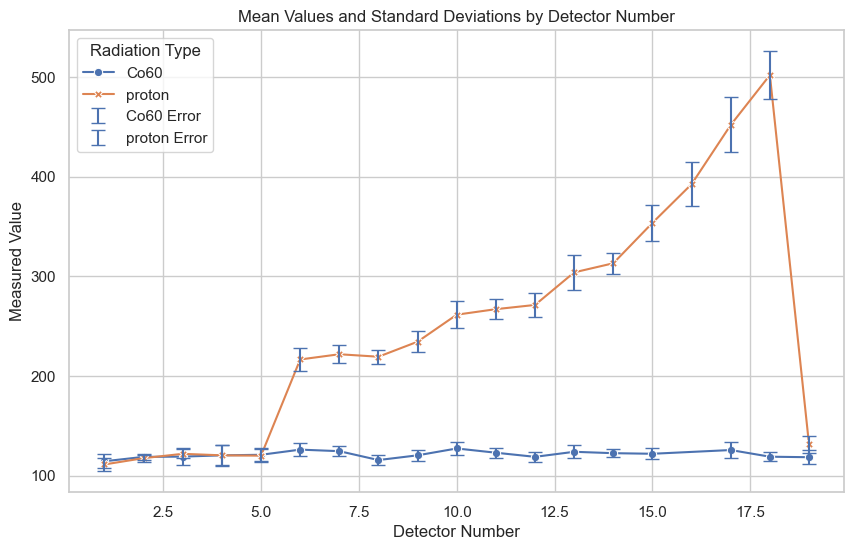

In [4]:
# Reset the index if df2 is a MultiIndex DataFrame
df2_reset = df2.reset_index()

# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Plot the mean values with line and scatter points
sns.lineplot(data=df2_reset, x='det_no', y='mean', hue='radiation', style='radiation', markers=True, dashes=False)

# Add error bars
for radiation_type in df2_reset['radiation'].unique():
    subset = df2_reset[df2_reset['radiation'] == radiation_type]
    plt.errorbar(subset['det_no'], subset['mean'], yerr=subset['std'], fmt='none', capsize=5, label=f'{radiation_type} Error')

plt.title('Mean Values and Standard Deviations by Detector Number')
plt.xlabel('Detector Number')
plt.ylabel('Measured Value')
plt.legend(title='Radiation Type')

# Bragg peak data from dosimetry and MC

In [5]:
df_bp_exp = pd.read_hdf(project_dir / 'data' / 'raw' / 'article-plots.h5', key='bp_exp')
df_bp_mc = pd.read_hdf(project_dir / 'data' / 'raw' / 'article-plots.h5', key='bp_mc')

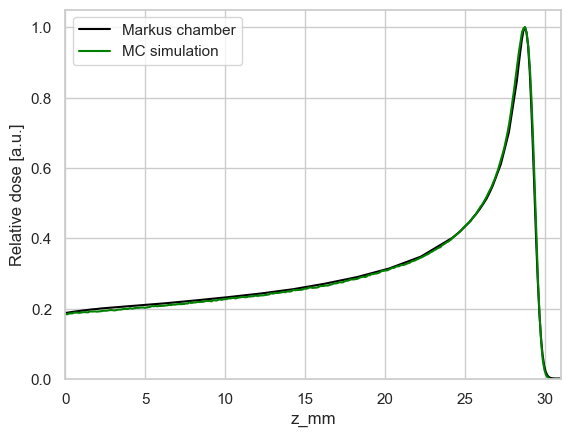

In [6]:
fig, ax_up = plt.subplots(nrows=1, sharex=True)
df_bp_exp.plot(ax=ax_up, x='Depth', y='Signal', label='Markus chamber', color='black', style='-')
df_bp_mc.plot(ax=ax_up, x='z_mm', y='dose', label='MC simulation', color='green', style='-')
ax_up.set_ylim(0,1.05)
ax_up.set_xlim(0, 31)
ax_up.set_ylabel("Relative dose [a.u.]");

# Detector positions

In [7]:
df_pos = pd.read_excel(project_dir / 'data' / 'raw' / 'foils_phantom.xlsx', 
sheet_name='Arkusz1', 
skiprows=6, 
nrows=32, 
usecols="A,D:E",
names=["det_no", "det_thick", "det_end"])
# drop row no 5
df_pos.drop(5, inplace=True)
df_pos['det_begin'] = df_pos.det_end - df_pos.det_thick
df_pos['det_mid'] = (df_pos.det_begin + df_pos.det_end) / 2
df_pos

,det_no,det_thick,det_end,det_begin,det_mid
0,1,0.44935,0.449350,0.000000,0.224675
1,2,0.44935,0.898700,0.449350,0.674025
2,3,0.44935,1.348050,0.898700,1.123375
3,4,0.44935,1.797400,1.348050,1.572725
4,5,0.44935,2.246750,1.797400,2.022075
6,6,0.44935,20.905925,20.456575,20.681250
7,7,0.44935,21.355275,20.905925,21.130600
8,8,0.44935,21.804625,21.355275,21.579950
9,9,0.44935,22.253975,21.804625,22.029300
10,10,0.44935,22.703325,22.253975,22.478650


In [8]:
# join df_reset with df_pos on det_no
df_reset_pos = df2_reset.join(df_pos.set_index('det_no'), on='det_no')
df_reset_pos

,radiation,det_no,mean,std,det_thick,det_end,det_begin,det_mid
0,Co60,1,114.411392,7.156181,0.44935,0.449350,0.000000,0.224675
1,Co60,2,118.817726,3.122446,0.44935,0.898700,0.449350,0.674025
2,Co60,3,119.080567,8.178193,0.44935,1.348050,0.898700,1.123375
3,Co60,4,120.368176,10.675350,0.44935,1.797400,1.348050,1.572725
4,Co60,5,120.913881,6.700715,0.44935,2.246750,1.797400,2.022075
5,Co60,6,126.101122,6.862605,0.44935,20.905925,20.456575,20.681250
6,Co60,7,124.544120,5.154877,0.44935,21.355275,20.905925,21.130600
7,Co60,8,115.630126,4.573181,0.44935,21.804625,21.355275,21.579950
8,Co60,9,120.383544,5.396862,0.44935,22.253975,21.804625,22.029300
9,Co60,10,127.261750,6.388419,0.44935,22.703325,22.253975,22.478650


(0.0, 30.0)

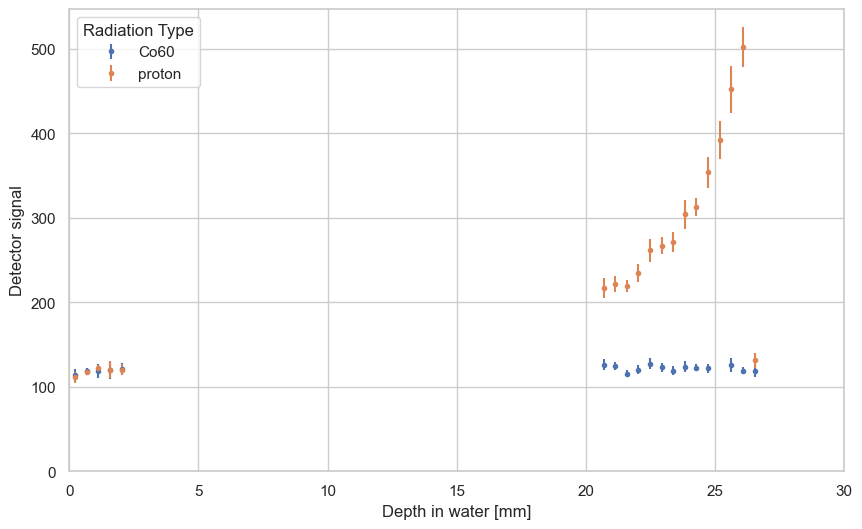

In [9]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean'], yerr=subset['std'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Detector signal')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

# Dose per detector

In [10]:
df_bp_mc

,zlower_cm,zupper_cm,dose,r.err,z_mm,dose_Gy
26,0.00,0.01,0.184743,0.0033,0.05,20.000000
27,0.01,0.02,0.184782,0.0034,0.15,20.004237
28,0.02,0.03,0.187052,0.0049,0.25,20.249965
29,0.03,0.04,0.186947,0.0041,0.35,20.238667
30,0.04,0.05,0.187195,0.0049,0.45,20.265499
...,...,...,...,...,...,...
421,3.95,3.96,0.000006,0.4542,39.55,0.000676
422,3.96,3.97,0.000016,0.5727,39.65,0.001760
423,3.97,3.98,0.000025,0.7804,39.75,0.002744
424,3.98,3.99,0.000028,0.7334,39.85,0.003082


In [11]:
# create spline interpolator object from scipy for x = df_bp_mc.z_mm and y = df_bp_mc.dose
from scipy.interpolate import interp1d
f = interp1d(df_bp_mc.z_mm, df_bp_mc.dose, kind='cubic')

In [12]:
df_bp_mc.iloc[0].dose

0.1847426230791307

In [13]:
# for such rows of df_reset_pos where radiation is 'proton' calculate 'dose' as f(df_reset_pos.det_mid)
entrance_dose_protons_Gy = 5
dose_Co60 = 5
df_reset_pos.loc[df_reset_pos.radiation == 'proton', 'dose'] = f(df_reset_pos[df_reset_pos.radiation == 'proton'].det_mid) / df_bp_mc.iloc[0].dose * entrance_dose_protons_Gy
df_reset_pos.loc[df_reset_pos.radiation == 'Co60', 'dose'] = dose_Co60

In [14]:
df_reset_pos['signal_per_Gy'] = df_reset_pos['mean'] / df_reset_pos['dose']
df_reset_pos

,radiation,det_no,mean,std,det_thick,det_end,det_begin,det_mid,dose,signal_per_Gy
0,Co60,1,114.411392,7.156181,0.44935,0.449350,0.000000,0.224675,5.000000,22.882278
1,Co60,2,118.817726,3.122446,0.44935,0.898700,0.449350,0.674025,5.000000,23.763545
2,Co60,3,119.080567,8.178193,0.44935,1.348050,0.898700,1.123375,5.000000,23.816113
3,Co60,4,120.368176,10.675350,0.44935,1.797400,1.348050,1.572725,5.000000,24.073635
4,Co60,5,120.913881,6.700715,0.44935,2.246750,1.797400,2.022075,5.000000,24.182776
5,Co60,6,126.101122,6.862605,0.44935,20.905925,20.456575,20.681250,5.000000,25.220224
6,Co60,7,124.544120,5.154877,0.44935,21.355275,20.905925,21.130600,5.000000,24.908824
7,Co60,8,115.630126,4.573181,0.44935,21.804625,21.355275,21.579950,5.000000,23.126025
8,Co60,9,120.383544,5.396862,0.44935,22.253975,21.804625,22.029300,5.000000,24.076709
9,Co60,10,127.261750,6.388419,0.44935,22.703325,22.253975,22.478650,5.000000,25.452350


(0.0, 30.0)

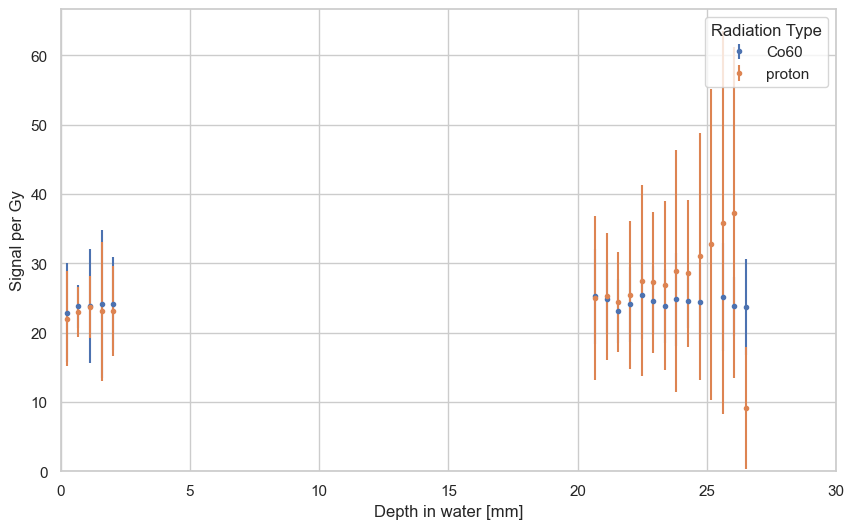

In [15]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['signal_per_Gy'], yerr=subset['std'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Signal per Gy')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

In [16]:
df_reset_pos

,radiation,det_no,mean,std,det_thick,det_end,det_begin,det_mid,dose,signal_per_Gy
0,Co60,1,114.411392,7.156181,0.44935,0.449350,0.000000,0.224675,5.000000,22.882278
1,Co60,2,118.817726,3.122446,0.44935,0.898700,0.449350,0.674025,5.000000,23.763545
2,Co60,3,119.080567,8.178193,0.44935,1.348050,0.898700,1.123375,5.000000,23.816113
3,Co60,4,120.368176,10.675350,0.44935,1.797400,1.348050,1.572725,5.000000,24.073635
4,Co60,5,120.913881,6.700715,0.44935,2.246750,1.797400,2.022075,5.000000,24.182776
5,Co60,6,126.101122,6.862605,0.44935,20.905925,20.456575,20.681250,5.000000,25.220224
6,Co60,7,124.544120,5.154877,0.44935,21.355275,20.905925,21.130600,5.000000,24.908824
7,Co60,8,115.630126,4.573181,0.44935,21.804625,21.355275,21.579950,5.000000,23.126025
8,Co60,9,120.383544,5.396862,0.44935,22.253975,21.804625,22.029300,5.000000,24.076709
9,Co60,10,127.261750,6.388419,0.44935,22.703325,22.253975,22.478650,5.000000,25.452350


In [18]:
# # divide df_reset_pos.dose for radiation=protons by the dose for radiation=Co60 for the same det_id
# df_reset_pos['eff'] = np.nan
# for row in df_reset_pos.loc[df_reset_pos.radiation == 'proton'].iterrows():
#     print(df.iloc[row].det_no)
# df_reset_pos
